In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import networkx as nx
import matplotlib.colors as mcolors
# warnings.simplefilter(action='ignore', category=FutureWarning)
# pd.options.display.max_rows = None
# pd.options.display.max_columns = None
import glob as glob
import math


In [2]:
print(pd.__version__)

1.5.2


#### read in csv amyloid pos and negative for adni and a4 
- this code runs with the graph_env environment which uses pandas 1.5.2 instead of 2.1 that matteo made for mci_mri_graph env


### sort the data into quartiles based on centiloid value

In [3]:
merged_adni_at_amypos_bi_harm = pd.read_csv('./adni/merged_adni_at_amy_pos_bi_harm.csv')
merged_a4_at_amypos_bi_harm = pd.read_csv('./a4/merged_a4_at_amy_pos_bi_harm.csv')

In [4]:
merged_adni_at_amypos_bi_harm

,RID,PUTAMEN,PRECUNEUS,CAUDATE,SUPERIORFRONTAL,BANKSSTS,FUSIFORM,INSULA,SUPRAMARGINAL,POSTCENTRAL,...,TRANSVERSETEMPORAL,PALLIDUM,INFERIORPARIETAL,TRACER,LATERALOCCIPITAL,MIDDLETEMPORAL,PERICALCARINE,PARACENTRAL,INFERIORTEMPORAL,ACCUMBENS_AREA
0,31,1.262,1.529,1.172,1.491,1.394,1.295,1.206,1.458,1.541,...,1.484,1.572,1.575,FBP,1.587,1.505,1.103,1.406,1.532,1.476
1,112,1.822,2.140,1.118,2.215,2.009,2.015,1.905,1.947,1.606,...,1.746,1.673,1.948,FBP,1.529,2.057,1.644,1.759,2.480,1.428
2,120,1.372,1.576,1.338,1.651,1.539,1.494,1.314,1.731,1.675,...,1.209,1.335,1.820,FBP,1.845,1.795,1.500,1.584,1.733,0.962
3,142,1.402,1.474,1.298,1.466,1.539,1.446,1.557,1.540,1.467,...,1.136,1.548,1.692,FBP,1.598,2.280,1.638,1.387,1.960,2.485
4,210,1.390,1.619,1.283,1.493,1.671,1.606,1.288,1.779,1.656,...,1.298,1.536,1.882,FBP,2.025,1.998,1.419,1.568,1.977,1.160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,6572,1.268,1.659,1.493,1.537,2.044,1.792,1.157,1.971,1.824,...,0.808,1.692,2.571,FBB,2.041,2.427,1.108,1.350,2.434,1.935
407,6575,1.394,1.360,1.264,1.420,1.304,1.400,1.333,1.507,1.372,...,1.215,1.533,1.583,FBB,1.528,1.552,1.066,1.494,1.574,1.613
408,6580,1.604,1.552,1.344,1.629,1.535,1.494,1.281,1.727,1.649,...,1.230,1.612,1.743,FBB,1.766,1.688,1.408,1.625,1.857,1.519
409,6581,1.440,1.186,1.335,1.343,1.198,1.284,1.121,1.414,1.401,...,0.997,1.632,1.484,FBB,1.618,1.574,0.995,1.305,1.613,1.366


In [23]:
mean_a4 = merged_a4_at_amypos_bi_harm['CENTILOIDS'].mean()
mean_adni = merged_adni_at_amypos_bi_harm['CENTILOIDS'].mean()
print(mean_a4)
print(mean_adni)

66.58628418230562
78.08515815085158


#### do histogram of centiloid values across adni and a4 
- adni has higher centiloid values because a4 is anti-amyloid treatment in asymptomatic ad 
- makes sense that a4 has slightly lower centiloids than adni because it's selected by being asymptomatic 
- this probably means that the tau is also lower in a4 patients 


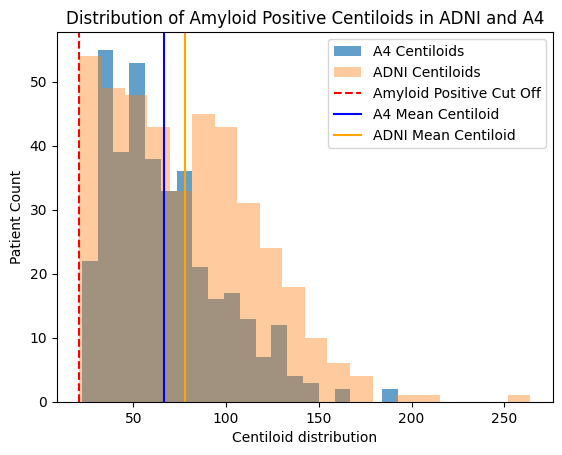

In [28]:
fig,ax = plt.subplots()
ax.hist(merged_a4_at_amypos_bi_harm['CENTILOIDS'],bins=20,label="A4 Centiloids",alpha=.7)
ax.hist(merged_adni_at_amypos_bi_harm['CENTILOIDS'],bins=20,label="ADNI Centiloids",alpha=.4)
ax.set_xlabel("Centiloid distribution")
ax.set_ylabel("Patient Count")
ax.axvline(x=21, color='red', linestyle='--', label='Amyloid Positive Cut Off')
ax.axvline(x=mean_a4, color='blue', linestyle='-', label='A4 Mean Centiloid')
ax.axvline(x=mean_adni, color='orange', linestyle='-', label='ADNI Mean Centiloid')
ax.legend()
plt.title("Distribution of Amyloid Positive Centiloids in ADNI and A4")
plt.show()


#### sort adni data into centiloid 

In [6]:
# Calculate quartiles for each patient's 'CENTILOIDS' values
merged_adni_at_amypos_bi_harm['QUARTILE'] = pd.qcut(merged_adni_at_amypos_bi_harm['CENTILOIDS'], q=4, labels=False)

# Initialize empty DataFrames for each quartile
quartile_dfs = [pd.DataFrame(columns=merged_adni_at_amypos_bi_harm.columns) for _ in range(4)]

# Sort patients into quartile DataFrames
for index, row in merged_adni_at_amypos_bi_harm.iterrows():
    quartile_num = row['QUARTILE']
    quartile_dfs[quartile_num] = quartile_dfs[quartile_num].append(row, ignore_index=True)

# Remove the 'QUARTILE' column from each quartile DataFrame
for i in range(4):
    quartile_dfs[i] = quartile_dfs[i].drop(columns=['QUARTILE'])




/tmp/ipykernel_3002692/667071555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quartile_dfs[quartile_num] = quartile_dfs[quartile_num].append(row, ignore_index=True)


In [7]:
print(merged_a4_at_amypos_bi_harm)

           RID  PUTAMEN  PRECUNEUS  CAUDATE  SUPERIORFRONTAL  BANKSSTS  \
0    B10423472    1.341      1.079    1.036            1.047     1.223   
1    B10693248    1.419      1.114    1.030            0.979     1.273   
2    B10709603    1.583      1.040    1.133            0.898     1.184   
3    B10904689    1.214      1.218    0.991            1.011     1.173   
4    B11089276    1.679      1.160    1.269            1.049     1.268   
..         ...      ...        ...      ...              ...       ...   
368  B92372599    1.453      1.072    0.965            0.998     1.173   
369  B97841288    1.651      1.321    0.946            1.151     1.237   
370  B98032541    1.308      1.384    0.894            1.237     1.670   
371  B99033399    1.315      1.110    1.015            0.994     1.138   
372  B99860801    1.331      0.976    0.976            0.890     1.014   

     FUSIFORM  INSULA  SUPRAMARGINAL  POSTCENTRAL  ...  TRANSVERSETEMPORAL  \
0       1.188   1.113          0.

##### create separate data frames based on the new quartiles

In [8]:
#divide into quartiles based on centiloids column 
#the thing is 903 total patients but I want to divide them into quartiles 

cent_low = quartile_dfs[0]
cent_med_low = quartile_dfs[1]
cent_med_high = quartile_dfs[2]
cent_high = quartile_dfs[3]


In [9]:
merged_adni_at_amypos_bi_harm[['CENTILOIDS','QUARTILE']]

,CENTILOIDS,QUARTILE
0,97.0,2
1,89.0,2
2,32.0,0
3,107.0,3
4,54.0,1
...,...,...
406,115.0,3
407,89.0,2
408,142.0,3
409,28.0,0


#### Quartiles seem reasonably well aligned with AD pathology 
- centiloids are scaled such that 0 is no pathology and 100 is advanced pathology, so plotting thr quartiles seem to be reasonably well aligned based on the histrogram plotted 
- classes are also numerically balanced

<AxesSubplot: >

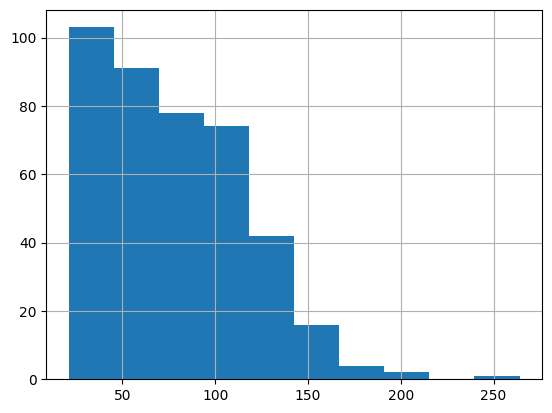

In [10]:
merged_adni_at_amypos_bi_harm['CENTILOIDS'].hist()

In [11]:
#classes are reasonably well balanced 
print(cent_low.shape)
print(cent_med_low.shape)
print(cent_med_high.shape)
print(cent_high.shape)


(103, 35)
(107, 35)
(100, 35)
(101, 35)


#### also check the centiloid ranges for each quartiles
##### it makes sense that the highest quartile would have the largest range because most of the data is cented 20-100 ish abased on the histogram 

In [12]:
low_range= [cent_low['CENTILOIDS'].min(),cent_low['CENTILOIDS'].max()]
med_low_range = [cent_med_low['CENTILOIDS'].min(),cent_med_low['CENTILOIDS'].max()]
med_high_range = [cent_med_high['CENTILOIDS'].min(),cent_med_high['CENTILOIDS'].max()]
high_range = [cent_high['CENTILOIDS'].min(),cent_high['CENTILOIDS'].max()]
print(f"centiloid range low amy pos quartile {low_range}")
print(f"centiloid range med low amy pos quartile {med_low_range}")
print(f"centiloid range med high amy pos quartile {med_high_range}")
print(f"centiloid range high amy pos quartile {high_range}")


centiloid range low amy pos quartile [21.0, 45.0]
centiloid range med low amy pos quartile [46.0, 75.0]
centiloid range med high amy pos quartile [76.0, 103.0]
centiloid range high amy pos quartile [104.0, 264.0]


##### save the adni centiloid quartiles csvs to use for graph construction

In [13]:
#save the quartile csvs 

cent_low.to_csv('./adni/adni_amy_tau_merged_cent_low_quartile.csv', index=False)
cent_med_low.to_csv('./adni/adni_amy_tau_merged_cent_med_low_quartile.csv', index=False)
cent_med_high.to_csv('./adni/adni_amy_tau_merged_cent_med_high_quartile.csv',index=False)
cent_high.to_csv('./adni/adni_amy_tau_merged_cent_high_quartile.csv',index=False)

- Only keep patients rows from most recent scan 


In [14]:
# #drop duplicate rows so that only the last visit row is still there 
# adni_amy_filtered = adni_amy.drop_duplicates(subset='RID',keep='last')
# #now it only has rows with the last visit 
# adni_amy_filtered = adni_amy.reset_index(drop=True)



# adni_amy['SCANDATE']= pd.to_datetime(adni_amy['SCANDATE'])
# #find most recent scan 
# most_recent_scan_date = adni_amy['SCANDATE'].max()
# #filter df to only include rows with most recent scan date 
# most_recent_scan = adni_amy[adni_amy['SCANDATE']==most_recent_scan_date]
# #select cols to keep 
# cols_to_keep = ['RID','SCANDATE','TRACER','CENTILOIDS']
# adni_amy_filtered = most_recent_scan[cols_to_keep]
# print(adni_amy_filtered)

* Task 1: 
* clean A4 data 
* I think that the A4_processed.csv has both amyloid and tau, but also includes patients with amyloid and no tau so just drop rows where the tau col is empty 
* A4_PETSUVR_PRV2_15_Aug2023 has id, visit code, and composite centiloid so use this for centiloid 

* TAUSUVR_15Aug2023 has the regional survs 


In [15]:
# Calculate quartiles for each patient's 'CENTILOIDS' values
merged_a4_at_amypos_bi_harm['quartile'] = pd.qcut(merged_a4_at_amypos_bi_harm['CENTILOIDS'], q=4, labels=False)

# Initialize empty DataFrames for each quartile
quartile_dfs = [pd.DataFrame(columns=merged_a4_at_amypos_bi_harm.columns) for _ in range(4)]

# Sort patients into quartile DataFrames
for index, row in merged_a4_at_amypos_bi_harm.iterrows():
    quartile_num = row['quartile']
    quartile_dfs[quartile_num] = quartile_dfs[quartile_num].append(row, ignore_index=True)

# Remove the 'QUARTILE' column from each quartile DataFrame
for i in range(4):
    quartile_dfs[i] = quartile_dfs[i].drop(columns=['quartile'])


/tmp/ipykernel_3002692/2932986344.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quartile_dfs[quartile_num] = quartile_dfs[quartile_num].append(row, ignore_index=True)


<AxesSubplot: >

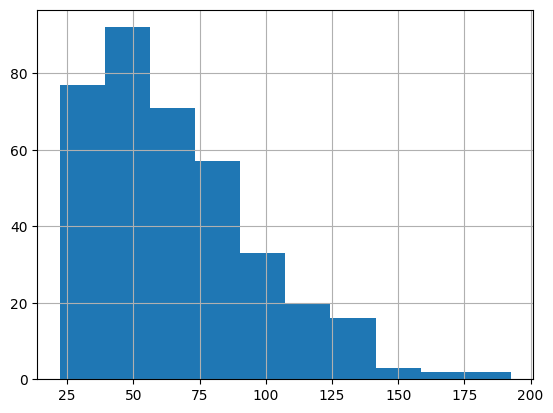

In [16]:
merged_a4_at_amypos_bi_harm['CENTILOIDS'].hist()

In [17]:
a4_cent_low = quartile_dfs[0]
a4_cent_med_low = quartile_dfs[1]
a4_cent_med_high = quartile_dfs[2]
a4_cent_high = quartile_dfs[3]

In [18]:
#classes are reasonably well balanced 
print(a4_cent_low.shape)
print(a4_cent_med_low.shape)
print(a4_cent_med_high.shape)
print(a4_cent_high.shape)

(101, 35)
(86, 35)
(94, 35)
(92, 35)


In [19]:
a4_low_range= [a4_cent_low['CENTILOIDS'].min(),a4_cent_low['CENTILOIDS'].max()]
a4_med_low_range = [a4_cent_med_low['CENTILOIDS'].min(),a4_cent_med_low['CENTILOIDS'].max()]
a4_med_high_range = [a4_cent_med_high['CENTILOIDS'].min(),a4_cent_med_high['CENTILOIDS'].max()]
a4_high_range = [a4_cent_high['CENTILOIDS'].min(),a4_cent_high['CENTILOIDS'].max()]
print(f"centiloid range low amy pos quartile {a4_low_range}")
print(f"centiloid range med low amy pos quartile {a4_med_low_range}")
print(f"centiloid range med high amy pos quartile {a4_med_high_range}")
print(f"centiloid range high amy pos quartile {a4_high_range}")

centiloid range low amy pos quartile [22.286, 42.424]
centiloid range med low amy pos quartile [44.255, 60.731]
centiloid range med high amy pos quartile [62.562, 82.699]
centiloid range high amy pos quartile [84.53, 192.541]


##### save a4 quartiles for graph construction 


In [20]:
#save the quartile csvs 
a4_cent_low.to_csv('./a4/a4_amy_tau_merged_cent_low_quartile.csv',index=False)
a4_cent_med_low.to_csv('./a4/a4_amy_tau_merged_cent_med_low_quartile.csv',index=False)
a4_cent_med_high.to_csv('./a4/a4_amy_tau_merged_cent_med_high_quartile.csv',index=False)
a4_cent_high.to_csv('./a4/a4_adni_amy_tau_merged_cent_high_quartile.csv',index=False)